In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


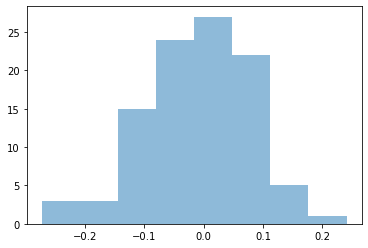

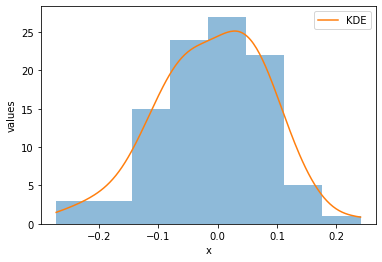

In [2]:
N = 100
mu, standard = 0, 0.1
x = np.random.normal(mu, standard, size=N)

fig, ax = plt.subplots()
bin_width = 2*sp.stats.iqr(x)*(len(x))**(-1/3)
max_val = np.max(x)
min_val = np.min(x)
bin_number = int((max_val-min_val)/bin_width)

n, bins, _ = ax.hist(x, bins=bin_number, label='x', alpha=0.5)
#fig, ax = plt.subplots(figsize=(6, 4))
x_ax = np.linspace(x.min(), x.max(), num = 200)
gauss = np.zeros((N,200))
for i in range(N):
    gauss[i,:] = sp.stats.norm.pdf(x_ax, loc = x[i], scale = 1.06*x.std()*x.size**(-0.2))
    
gauss_sum = np.sum(gauss, axis = 0)

norm = sp.integrate.trapz(gauss_sum, dx = (x.max()-x.min())/200)
gauss_sum_norm = gauss_sum*((bins[-1]-bins[0])/bin_number*n.sum())/norm

fig, ax = plt.subplots(figsize=(6, 4))
#ax.legend(loc='upper left')
ax.set_ylabel('values')
ax.set_xlabel('x')
n, bins, _ = plt.hist(x, bins = bin_number, alpha = 0.5)
plt.plot(x_ax, gauss_sum_norm, label = 'KDE')
plt.legend(loc = 'upper right')
plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2020-11-17 17:51:59--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2020-11-17 17:52:03--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uce0b9eb18d985c2defb5299d691.dl.dropboxusercontent.com/cd/0/inline/BDYUejHyl9z1wm2QlN8_FpoTU7T9lFIw-w4KJAHTJFaq8auScORO6_N1xfBIXH9X9kRPfUoZaFrHZcDzSnma0mfr4DrdG7jdUxdihIPQObFsvw/file# [segue]
--2020-11-17 17:52:04--  https://uce0b9eb18d985c2defb5299d691.dl.dropboxusercontent.com/cd/0/inline/BDYUejHyl9z1wm2QlN8_FpoTU7T9lFIw-w4KJAHTJFaq8auScORO6_N1xfBIXH9X9kRPfUoZaFrHZ

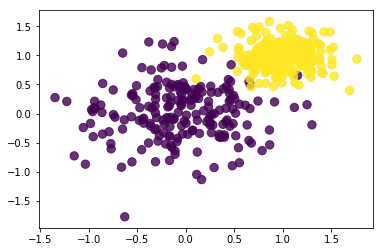

In [3]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

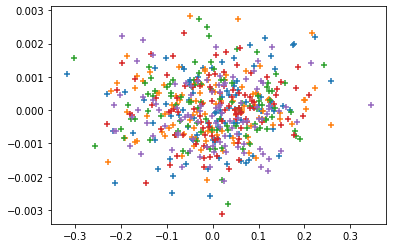

In [4]:
mean = [0, 2]
std = [0.1, 0.001]


fig, ax = plt.subplots()

for i in range(5):
    x1 = np.random.normal(mean[0], std[0], size=100)
    x2 = np.random.normal(mean[0], std[1], size = 100)
    #plt.plot(x1,x2,'*')
    ax.scatter(x=x1, y = x2, marker='+')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [5]:
#!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

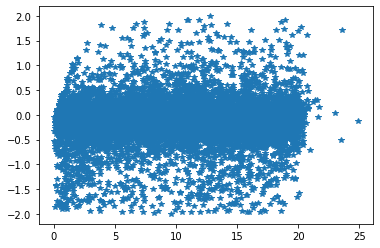

[-0.24681325 -0.12989732 -0.17463489 -0.16243032 -0.13319177 -0.13942494
 -0.10424032 -0.07879165 -0.10530914 -0.10090854 -0.03311745 -0.0914637
 -0.07868601 -0.13182509 -0.14368135 -0.12177526 -0.13945171 -0.16790314
 -0.12161063 -0.05222069]
[0.48732756 0.42182345 0.4262629  0.40975528 0.38458806 0.39801896
 0.43612876 0.46095775 0.44381378 0.42008083 0.43645245 0.47160631
 0.50159408 0.46371072 0.46224375 0.45553885 0.41060295 0.42074562
 0.40744313 0.37218506]


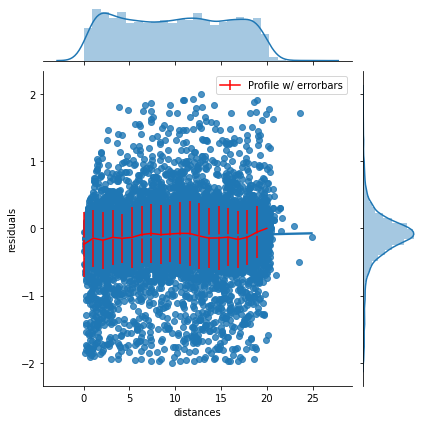

In [7]:
v = np.load('residuals_261.npy', allow_pickle = "true").item()
df = pd.DataFrame(v)

df = df[np.abs(df['residuals']) <2]
#df.describe()

plt.plot(df['distances'], df['residuals'], '*')
plt.show()

b, a, rv, pv, _ = sp.stats.linregress( df['distances'], df['residuals'])
g = sns.jointplot("distances", "residuals", data=df, kind="reg")

x = np.array([i + 1/2 for i in range(20)])
y_predicted = a + b*x
y_mean = np.zeros(20)
y_err = np.zeros(20)
residuals = df['residuals']
for i in range(20):
    y_mean[i] = residuals[(df['distances'] > i) & (df['distances'] < i+ 1)].mean()
    y_err[i] = residuals[(df['distances'] > i) & (df['distances'] < i+ 1)].std()
    
print(y_mean)
print(y_err)

x = np.linspace(0,20,20)
df = df.sort_values('distances')

y = np.zeros(len(x))
count = 0
prev = x[0]
erry = np.zeros(len(x))

for i in x[1:]:
    temp = df[df['distances'] < i]
    temp = temp[temp['distances']>=prev]
    y[count] = temp['residuals'].mean()
    erry[count] = temp['residuals'].std()
    count += 1
    prev = i
    
plt.errorbar(x,y,yerr=erry, color='red', label='Profile w/ errorbars')
plt.legend()
